# House Pricing

## Introduction

In this project, we will train regression models and compare their results over a Kaggle dataset. We will try to get the best performance in predicting the house prices.

## Data

We will work with house pricing datasets open-source on Kaggle. This dataset contains 18 features and 4551 data rows. \
The 18 features are:

1. date
2. price
3. bedrooms
4. bathrooms
5. sqft_living
6. sqft_lot
7. floors
8. waterfront
9. view
10. condition
11. sqft_above
12. sqft_basement
13. yr_built
14. yr_renovated
15. street
16. city
17. statezip
18. country

For details abour the data, visit: https://www.kaggle.com/datasets/shree1992/housedata/data

## Data analysis

### Importing the required libraries

In [72]:
#for data manipulation
import numpy as np
import pandas as pd
import datetime
from IPython.display import display, HTML, display_html
from itertools import chain,cycle

#for data visualization
import seaborn as sns
import matplotlib.pyplot as pl
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as colors

#for requesting additional data
import requests
from io import StringIO
import json
from urllib.request import urlopen

#for geo information
from geopy.geocoders import Nominatim
import folium

#for data modelling
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import lightgbm as ltb

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings(action="ignore"):
    fxn()


### Data cleaning

In [73]:
data = pd.read_csv("data.csv")
data = data.drop(columns=['country', 'street', 'date']) # drop the unimportant columns
data = data.loc[data['price'] != 0]
data = data.dropna()
data = data.drop_duplicates()

data['yr_built'] = pd.DatetimeIndex(data['yr_built']).year
data['yr_renovated'] = pd.DatetimeIndex(data['yr_renovated']).year

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1970,1970,Shoreline,WA 98133
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1970,1970,Seattle,WA 98119
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1970,1970,Kent,WA 98042
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1970,1970,Bellevue,WA 98008
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1970,1970,Redmond,WA 98052


In [74]:
print("Original data size: (4551, 18) \n New data set size: {}".format(data.shape))

Original data size: (4551, 18) 
 New data set size: (4551, 15)


### Adding latitude and longitude data

In [75]:
headers = {
    'authority': 'gist.githubusercontent.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-GB,en;q=0.9',
    'cache-control': 'max-age=0',
    'sec-ch-ua': '"Not A(Brand";v="99", "Google Chrome";v="121", "Chromium";v="121"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'none',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36',
}

response = requests.get(
    'https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data',
    headers=headers,
)

content = response.content.decode()
StringL = StringIO(content)
LatLon_data = pd.read_csv(StringL, sep = ',')

data[['State', 'ZIP']] = data['statezip'].str.split(' ', expand= True)
data = data.drop(columns= ['statezip', 'State'])
data['ZIP'] = data['ZIP'].astype(int)
data = data.merge(LatLon_data, how= 'inner', on='ZIP')

In [76]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,ZIP,LAT,LNG
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1970,1970,Shoreline,98133,47.740485,-122.342826
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1970,1970,Seattle,98119,47.638679,-122.370946
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1970,1970,Kent,98042,47.367737,-122.117029
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1970,1970,Bellevue,98008,47.605797,-122.099118
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1970,1970,Redmond,98052,47.680990,-122.120531


### Some general information about the data

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551 entries, 0 to 4550
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4551 non-null   float64
 1   bedrooms       4551 non-null   float64
 2   bathrooms      4551 non-null   float64
 3   sqft_living    4551 non-null   int64  
 4   sqft_lot       4551 non-null   int64  
 5   floors         4551 non-null   float64
 6   waterfront     4551 non-null   int64  
 7   view           4551 non-null   int64  
 8   condition      4551 non-null   int64  
 9   sqft_above     4551 non-null   int64  
 10  sqft_basement  4551 non-null   int64  
 11  yr_built       4551 non-null   int32  
 12  yr_renovated   4551 non-null   int32  
 13  city           4551 non-null   object 
 14  ZIP            4551 non-null   int32  
 15  LAT            4551 non-null   float64
 16  LNG            4551 non-null   float64
dtypes: float64(6), int32(3), int64(7), object(1)
memory 

In [78]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,ZIP,LAT,LNG
count,4.551000e+03,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.0,4551.0,4551.000000,4551.000000,4551.000000
mean,5.579059e+05,3.394639,2.155021,2132.372226,1.483528e+04,1.512195,0.006592,0.234674,3.449352,1822.221710,310.150516,1970.0,1970.0,98079.397056,47.567688,-122.204906
std,5.639299e+05,0.904595,0.776351,955.949708,3.596408e+04,0.538531,0.080932,0.765373,0.675160,854.452888,461.987629,0.0,0.0,53.048784,0.132885,0.157461
min,7.800000e+03,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1970.0,1970.0,98001.000000,47.216372,-122.473322
25%,3.262643e+05,3.000000,1.750000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1970.0,1970.0,98033.000000,47.493732,-122.324859
50%,4.650000e+05,3.000000,2.250000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1970.0,1970.0,98072.000000,47.585627,-122.232795
75%,6.575000e+05,4.000000,2.500000,2610.000000,1.097800e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1970.0,1970.0,98117.000000,47.678255,-122.117029
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,1970.0,1970.0,98354.000000,47.760785,-121.278786


<Figure size 600x600 with 0 Axes>

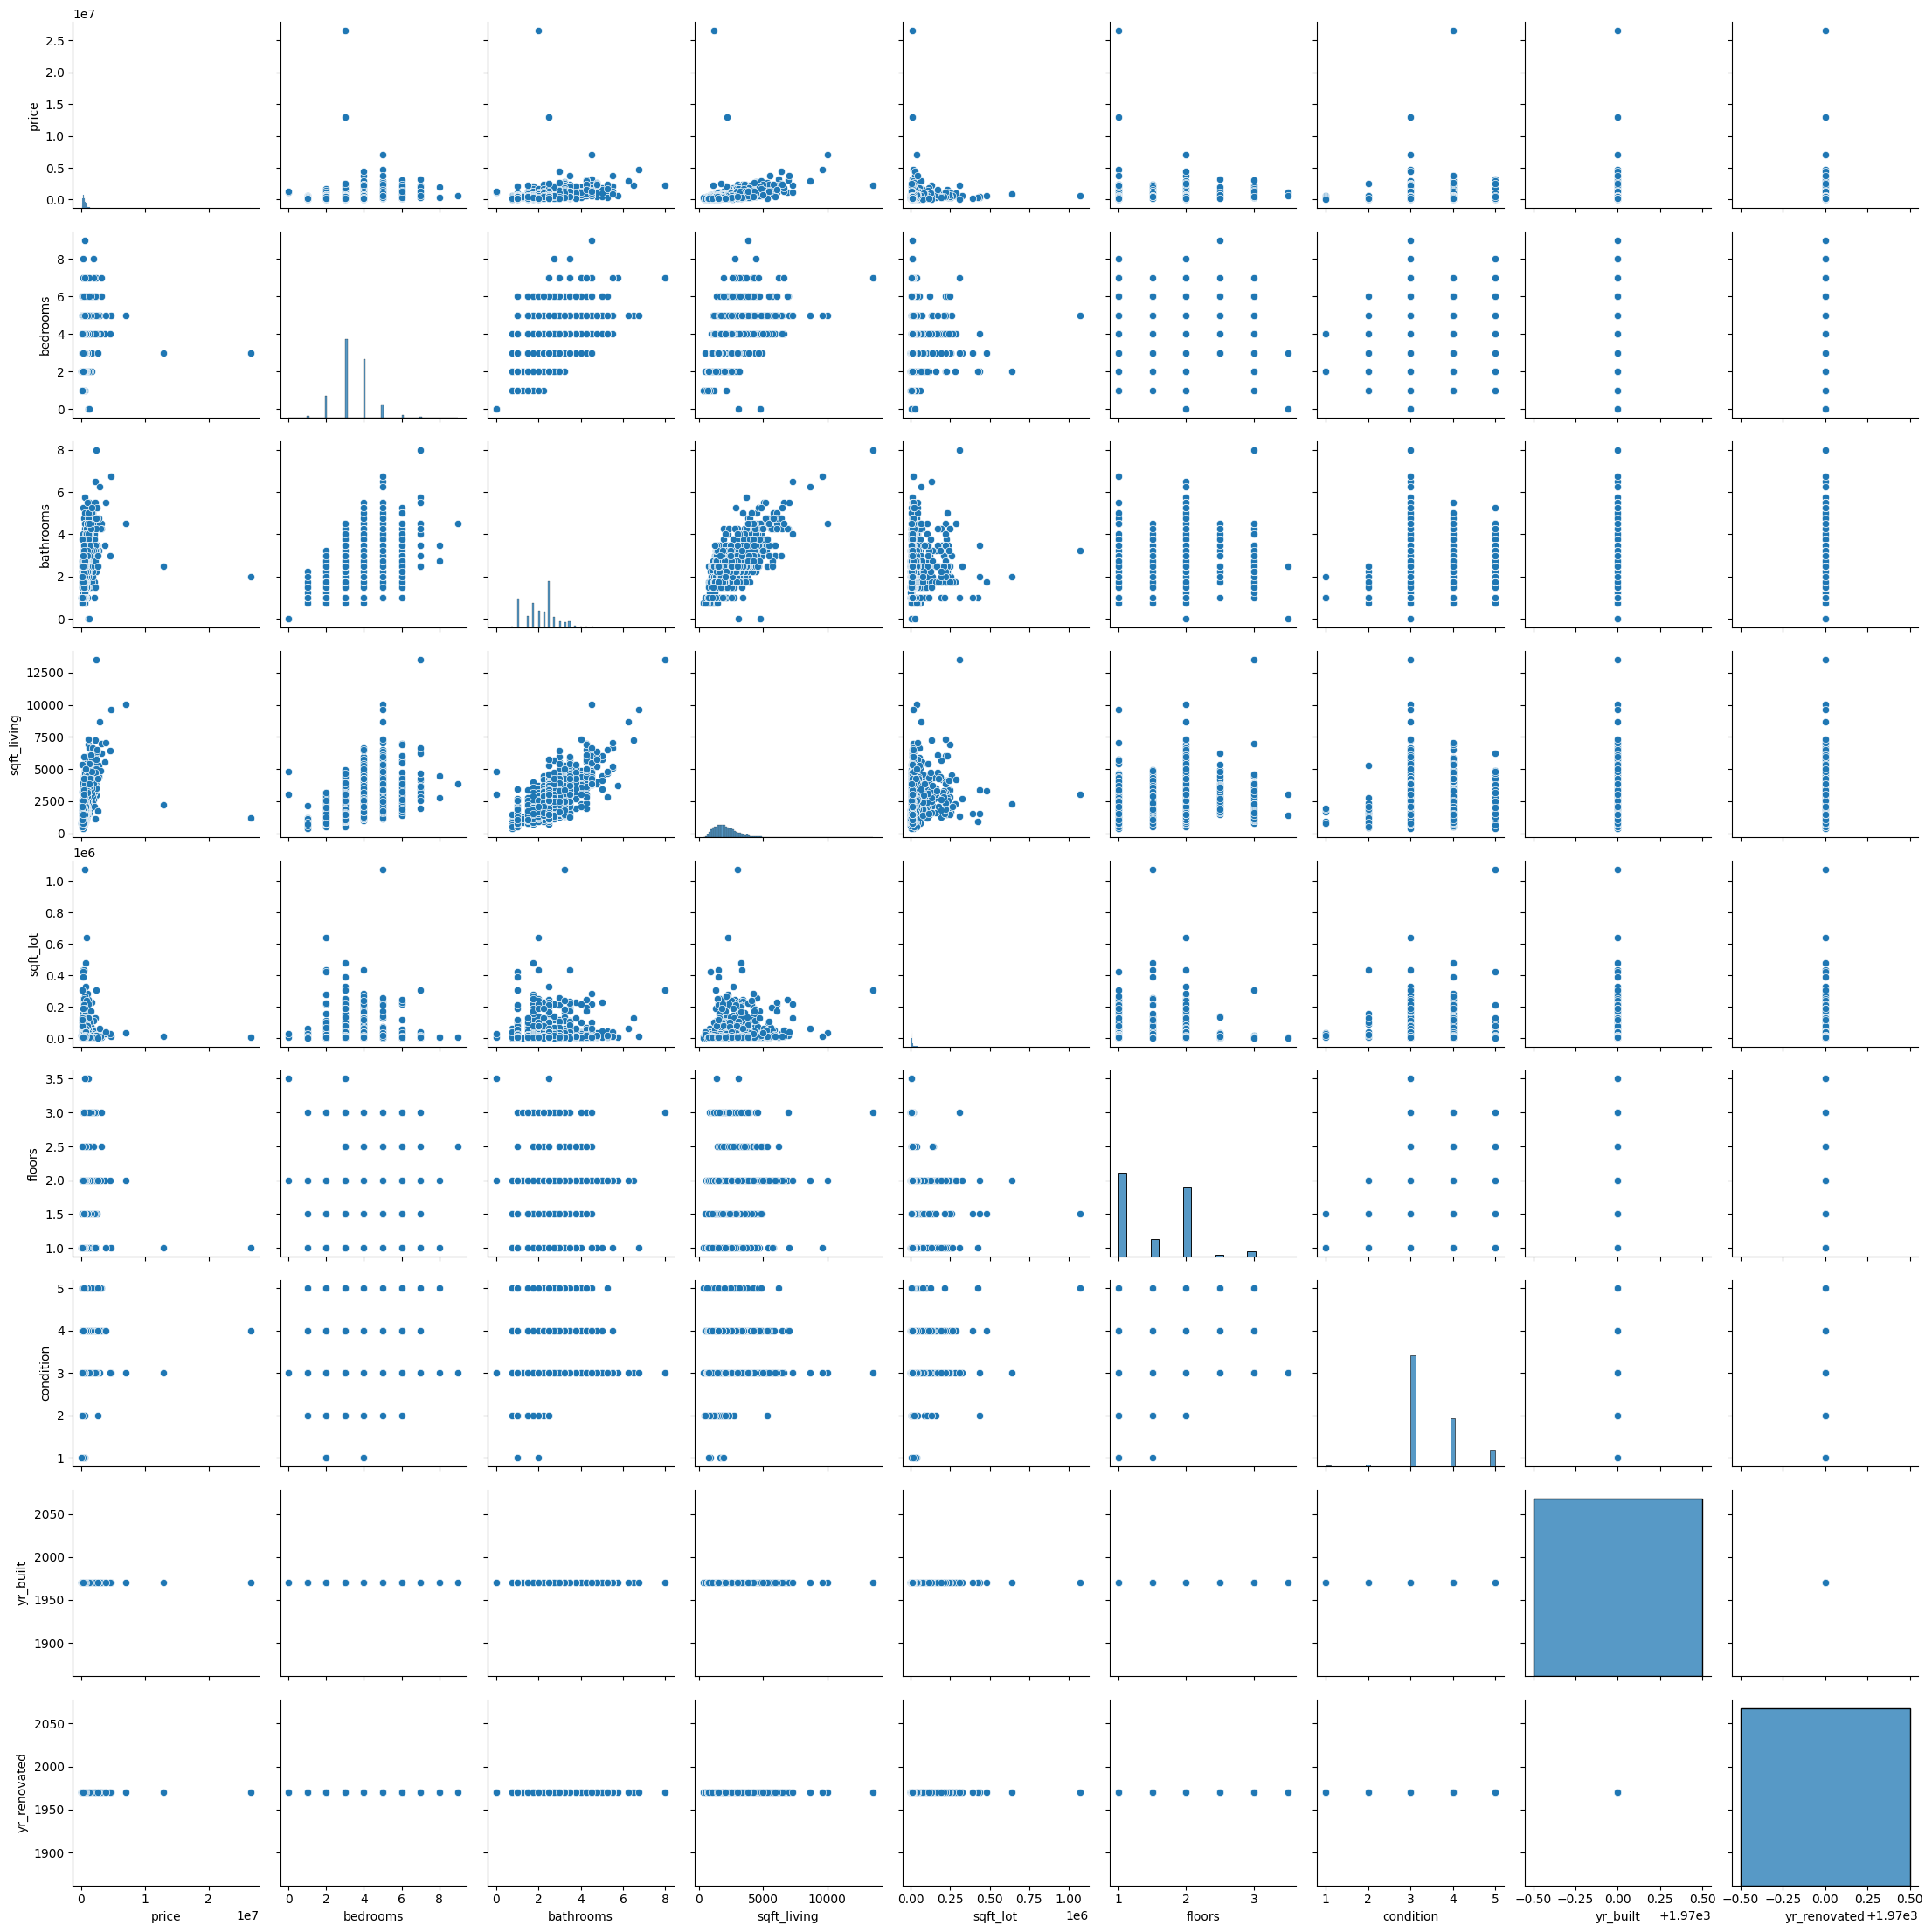

In [79]:
features = ['price', 'bedrooms','bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'yr_built', 'yr_renovated']

pl.figure(figsize=(6,6))
sns.pairplot(data[features])

As visually as in the data description, we can infer that the features "yr_renovated" and "yr_bulit" have almost the same values for every point of information; hence, we will get rid of them for our project.

In [80]:
data = data.drop(columns= ['yr_built', 'yr_renovated'])

Now we are going to generate some graphs about the average house prices in every postal location

In [81]:
mean_prices_data = data.copy()
mean_prices_data = mean_prices_data[['ZIP', 'LAT', 'LNG', 'price']]
# mean_prices_data['ZIP-city'] = mean_prices_data['ZIP'].astype(str) + ", " + mean_prices_data['city'].astype(str)
# mean_prices_data = mean_prices_data.drop(columns= ['ZIP', 'city'])

a = mean_prices_data.groupby(['ZIP'], as_index= False)[['price', 'LAT', 'LNG']].size()
b = mean_prices_data.groupby(['ZIP'], as_index= False)[['price', 'LAT', 'LNG']].mean()

mean_prices_data = a.merge(b, how= 'inner', on= 'ZIP')
mean_prices_data = mean_prices_data.rename(columns = {'price': 'Mean Price', 'size': 'Number of houses'})
mean_prices_data.head()


,ZIP,Number of houses,Mean Price,LAT,LNG
0,98001,66,2.616399e+05,47.310617,-122.263291
1,98002,35,2.299344e+05,47.308286,-122.216812
2,98003,48,2.994256e+05,47.304801,-122.316969
3,98004,71,1.372758e+06,47.618337,-122.205341
4,98005,29,7.787792e+05,47.614533,-122.168798


In [82]:
fig = px.scatter_mapbox(mean_prices_data, lat= 'LAT', lon= 'LNG', size = 'Mean Price', color= 'Number of houses')

fig.update_layout(mapbox_style="open-street-map", height= 600, width = 1000)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig.show()

In the image above the circle size indicates the mean prices while the color indicates the number of houses in every Postal location, by pointing at every city we can additionally see the mean price of the Zip code. We then compared the highest and lowest average house prices by zip location.

In [83]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: left;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

mean_prices_data_highest = mean_prices_data.sort_values(by= 'Mean Price', ascending= False).iloc[:5, :]
mean_prices_data_highest = mean_prices_data_highest.reset_index()
mean_prices_data_highest = mean_prices_data_highest.drop(columns= ['index'])

mean_prices_data_lowest = mean_prices_data.sort_values(by= 'Mean Price', ascending= True).iloc[:5, :]
mean_prices_data_lowest = mean_prices_data_lowest.reset_index()
mean_prices_data_lowest = mean_prices_data_lowest.drop(columns= ['index'])

display_side_by_side(mean_prices_data_highest, mean_prices_data_lowest, titles= ['Highest average house price ', 'Lowest average house price'])

,ZIP,Number of houses,Mean Price,LAT,LNG
0,98039,11,2.046559e+06,47.631695,-122.240405
1,98004,71,1.372758e+06,47.618337,-122.205341
2,98040,82,1.178638e+06,47.567779,-122.232795
3,98109,30,1.049846e+06,47.631863,-122.344267
4,98112,69,1.001604e+06,47.632810,-122.288511
,ZIP,Number of houses,Mean Price,LAT,LNG
0,98047,6,225233.333333,47.261769,-122.248889
1,98002,35,229934.371429,47.308286,-122.216812
2,98288,3,233000.000000,47.661553,-121.278786
3,98168,66,255738.349206,47.489569,-122.299960


In [84]:
most_mean_expensive_houses = mean_prices_data_highest['ZIP'].values.tolist()

y = []
for i in range(5):
    y0 = np.array(data.loc[data['ZIP'] == most_mean_expensive_houses[i]]['price'])
    y.append(y0)

fig = go.Figure()

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)']

for xd, yd, cls in zip(most_mean_expensive_houses, y, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=2,
            line_width=1,
            boxmean= 'sd')
        )

fig.update_layout(
    title='Dispersion of houses prices for the most 5 expensive cities',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=1000000,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig.show()

In [85]:
least_mean_expensive_houses = mean_prices_data_lowest['ZIP'].values.tolist()

y = []
for i in range(5):
    y0 = np.array(data.loc[data['ZIP'] == least_mean_expensive_houses[i]]['price'])
    y.append(y0)

fig = go.Figure()

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)']

for xd, yd, cls in zip(least_mean_expensive_houses, y, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=2,
            line_width=1,
            boxmean= 'sd')
        )

fig.update_layout(
    title='Dispersion of houses prices for the most 5 expensive cities',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=500000,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=250000,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig.show()

As we  can see there are many outliers concerning the house prices. We can set some limits on the data to have a more tractable one.

In [86]:
data = data.loc[(data['price'] <= 1000000) & 
                (data['bedrooms'] < 8) & 
                (data['bathrooms'] < 6) &
                (data['sqft_living'] < 7500) &
                (data['condition'] > 1) &
                (data['bedrooms'] > 1) &
                (data['view'] < 3)]
data.shape

(4075, 15)

## Model training

### Data split

In [87]:
train = data.copy()
cat_col = train.select_dtypes(include='object').columns.to_list()
# train = train.drop(columns= ['city', 'ZIP'])
X = train.drop(columns='price')
y = train['price']

for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### GBM Model

In [88]:
model_params = {'boosting_type': 'gbdt', 
                'colsample_bytree': 0.6, 
                'learning_rate': 0.05,
                'max_depth': -1, 
                'min_child_samples': 13, 
                'min_child_weight': 0.01, 
                'min_split_gain': 0.25,
                'n_jobs': -1, 
                'num_leaves': 80, 
                'objective': 'regression', 
                'random_state': 0, 
                'seed': 0,
                'reg_alpha': 1.0559559479313415,
                'reg_lambda': 1.0949294490500017e-06, 
                'subsample': 0.96, 
                'subsample_for_bin': 200000,
                'subsample_freq': 4, 
                'verbose': -1, 
                'metric': 'rmse',
            }

gmb_model = ltb.LGBMRegressor(**model_params)
gmb_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.05, metric='rmse',
              min_child_samples=13, min_child_weight=0.01, min_split_gain=0.25,
              n_jobs=-1, num_leaves=80, objective='regression', random_state=0,
              reg_alpha=1.0559559479313414, reg_lambda=1.0949294490500017e-06,
              seed=0, subsample=0.96, subsample_freq=4, verbose=-1)

In [89]:
y_pred1 = gmb_model.predict(X_test)

mse1 = mean_squared_error(y_test, y_pred1)
mae1 = mean_absolute_error(y_test, y_pred1)
r21 = r2_score(y_test, y_pred1)

print(f'Mean Squared Error (MSE): {mse1:.4f}')
print(f'Mean Absolute Error (MAE): {mae1:.4f}')
print(f'R-squared (R2): {r21:.4f}')

Mean Squared Error (MSE): 7924939038.9410
Mean Absolute Error (MAE): 60860.8937
R-squared (R2): 0.7928


### XGB model

In [90]:
XGB_model = xgb.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123, enable_categorical=True) 
XGB_model.fit(X_train, y_train)

c:\Users\bsar_\Venv\Py3.11BDA\Lib\site-packages\xgboost\core.py:160: UserWarning:

[00:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [91]:
y_pred2 = XGB_model.predict(X_test) 

mse2 = mean_squared_error(y_test, y_pred2)
mae2 = mean_absolute_error(y_test, y_pred2)
r22 = r2_score(y_test, y_pred2)

print(f'Mean Squared Error (MSE): {mse2:.4f}')
print(f'Mean Absolute Error (MAE): {mae2:.4f}')
print(f'R-squared (R2): {r22:.4f}')

Mean Squared Error (MSE): 8151269994.5435
Mean Absolute Error (MAE): 62288.0240
R-squared (R2): 0.7868


### Catboost Model

In [92]:
model = CatBoostRegressor(cat_features=cat_col,
                          n_estimators=1000,
                          random_seed=12,
                          verbose=100)

model.fit(X_train, y_train)

Learning rate set to 0.049348
0:	learn: 189890.5360140	total: 29.2ms	remaining: 29.1s


100:	learn: 87726.0636300	total: 2.42s	remaining: 21.5s
200:	learn: 78768.9504177	total: 4.8s	remaining: 19.1s
300:	learn: 73462.6650734	total: 6.91s	remaining: 16.1s
400:	learn: 68914.9080758	total: 9.43s	remaining: 14.1s
500:	learn: 65383.7329301	total: 12.3s	remaining: 12.3s
600:	learn: 62733.0220863	total: 15.1s	remaining: 10s
700:	learn: 60297.5505604	total: 18s	remaining: 7.67s
800:	learn: 58313.4185587	total: 20.7s	remaining: 5.14s
900:	learn: 56428.4918336	total: 23.5s	remaining: 2.59s
999:	learn: 54649.1459017	total: 26.4s	remaining: 0us


In [93]:
y_pred3 = model.predict(X_test)

mse3 = mean_squared_error(y_test, y_pred3)
mae3 = mean_absolute_error(y_test, y_pred3)
r23 = r2_score(y_test, y_pred3)

print(f'Mean Squared Error (MSE): {mse3:.4f}')
print(f'Mean Absolute Error (MAE): {mae3:.4f}')
print(f'R-squared (R2): {r23:.4f}')

Mean Squared Error (MSE): 7837530225.0531
Mean Absolute Error (MAE): 60562.0719
R-squared (R2): 0.7951


### Comparison of the models presented

In [94]:
y_test = pd.DataFrame(y_test).reset_index(drop = True).rename(columns={'price': 'Actual Price'})
y_pred1 = pd.DataFrame(y_pred1, columns = ['Prediction by GBM'])
y_pred2 = pd.DataFrame(y_pred2, columns = ['Prediction by XGB'])
y_pred3 = pd.DataFrame(y_pred3, columns = ['Prediction by Catboost'])

In [95]:
y_pred = [y_test, y_pred1, y_pred2, y_pred3]
y_pred = pd.concat(y_pred, axis = 1)
y_pred.head()

,Actual Price,Prediction by GBM,Prediction by XGB,Prediction by Catboost
0,913888.0,683797.923491,694543.062500,667705.801883
1,660000.0,627339.479547,686967.750000,661691.989389
2,717000.0,507206.938822,488774.281250,505627.420663
3,265000.0,227649.487526,277435.906250,231007.004598
4,187000.0,185594.709444,196884.796875,171448.342241


In [96]:
fig = px.scatter(y_pred, x= 'Actual Price', y= y_pred.columns[1:4], trendline="ols")
fig.show()

c:\Users\bsar_\Venv\Py3.11BDA\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [100]:
pd.DataFrame({'Mean Squared Error (MSE)': [f'{mse1:.4f}', f'{mse2:.4f}', f'{mse3:.4f}'],
              'Mean Absolute Error (MAE)': [f'{mae1:.4f}', f'{mae2:.4f}', f'{mae3:.4f}'],
              'R-squared (R2)': [f'{r21:.4f}', f'{r22:.4f}', f'{r23:.4f}']}).rename(index= {0: 'GBM Model', 1: 'XGB Model', 2: 'Catboost'})

,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared (R2)
GBM Model,7924939038.9410,60860.8937,0.7928
XGB Model,8151269994.5435,62288.0240,0.7868
Catboost,7837530225.0531,60562.0719,0.7951


## Conclusion

Overall,  we can see the three models produce good R squared values, all around 80% which can be considered adequate but not excellent for the predictions. In future projects, we can train other models to see how they react to the dataset used and try to get a better performance